# Inference and evaluation on the test dataset

In [1]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [2]:
import torch, torchvision

import mmseg
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
from mmseg.apis import set_random_seed

import mmcv
from mmcv import Config

import matplotlib.pyplot as plt
import os.path as osp
import numpy as np
from PIL import Image

In [3]:
# convert dataset annotation to semantic segmentation map
data_root = '.'
img_dir = 'train_img'
ann_dir = 'mask_img'

# define class and plaette for better visualization
classes = ('background', 'building')
palette = [[0, 0, 0], [0, 0, 255]]

In [4]:
config_file = 'mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = 'mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'
save_pth_path = 'mmsegmentation/building_checkpoint'

In [5]:
@DATASETS.register_module(force=True)
class RoadSemanticSegmentation(CustomDataset):
    CLASSES = classes
    PALETTE = palette
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.png', seg_map_suffix='.png', split=split, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None

In [6]:
cfg = Config.fromfile(config_file)

In [7]:
from mmseg.apis import set_random_seed

# add CLASSES and PALETTE to checkpoint
cfg.checkpoint_config.meta = dict(
    CLASSES=classes,
    PALETTE=palette)

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2

# modify loss function crossentropy
#cfg.model.decode_head.loss_decode = dict(type='CrossEntropyLoss', class_weight=[1, 2], use_sigmoid=False, loss_weight=1.0)

#cfg.model.test_cfg.mode = 'whole'
#del cfg['model']['test_cfg']['crop_size']
#del cfg['model']['test_cfg']['stride']

# Modify dataset type and path
cfg.dataset_type = 'RoadSemanticSegmentation'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 4
cfg.data.workers_per_gpu = 4

# Albumentations transforms settings
albu_train_transforms = [
    dict(
    type='OneOf',
    transforms=[
        dict(type='RandomRotate90', p=1.0)
    ], p=0.5),

    dict(
    type='OneOf',
    transforms=[
        dict(type='RandomBrightnessContrast',brightness_limit=0.1, contrast_limit=0.15, p=1.0),
        dict(type='CLAHE', clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=1.0),
        dict(type='HueSaturationValue', hue_shift_limit=15, sat_shift_limit=25, val_shift_limit=10, p=1.0),
    ], p=0.5)
]

# pipline
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 1.5)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Albu',
        transforms=albu_train_transforms,
        keymap=dict(img='image', gt_semantic_seg='mask'),
        update_pad_shape=True,
        ),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = '.'
cfg.data.train.img_dir = 'train_img'
cfg.data.train.ann_dir = 'mask_img'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'split/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = '.'
cfg.data.val.img_dir = 'train_img'
cfg.data.val.ann_dir = 'mask_img'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'split/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = '.'
cfg.data.test.img_dir = 'test_img'
cfg.data.test.ann_dir = 'mask_img'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'split/test.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = checkpoint_file

# Set up working dir to save files and logs.
cfg.work_dir = save_pth_path

cfg.runner.max_iters = 10000
cfg.log_config.interval = 10
cfg.evaluation.interval = 100
cfg.evaluation.save_best = 'mIoU'
cfg.checkpoint_config.interval = 2000

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cfg

/home/cuvic/satellite/RealSegformer/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: mmsegmentation/building_checkpoint/iter_10000.pth


/home/cuvic/satellite/RealSegformer/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


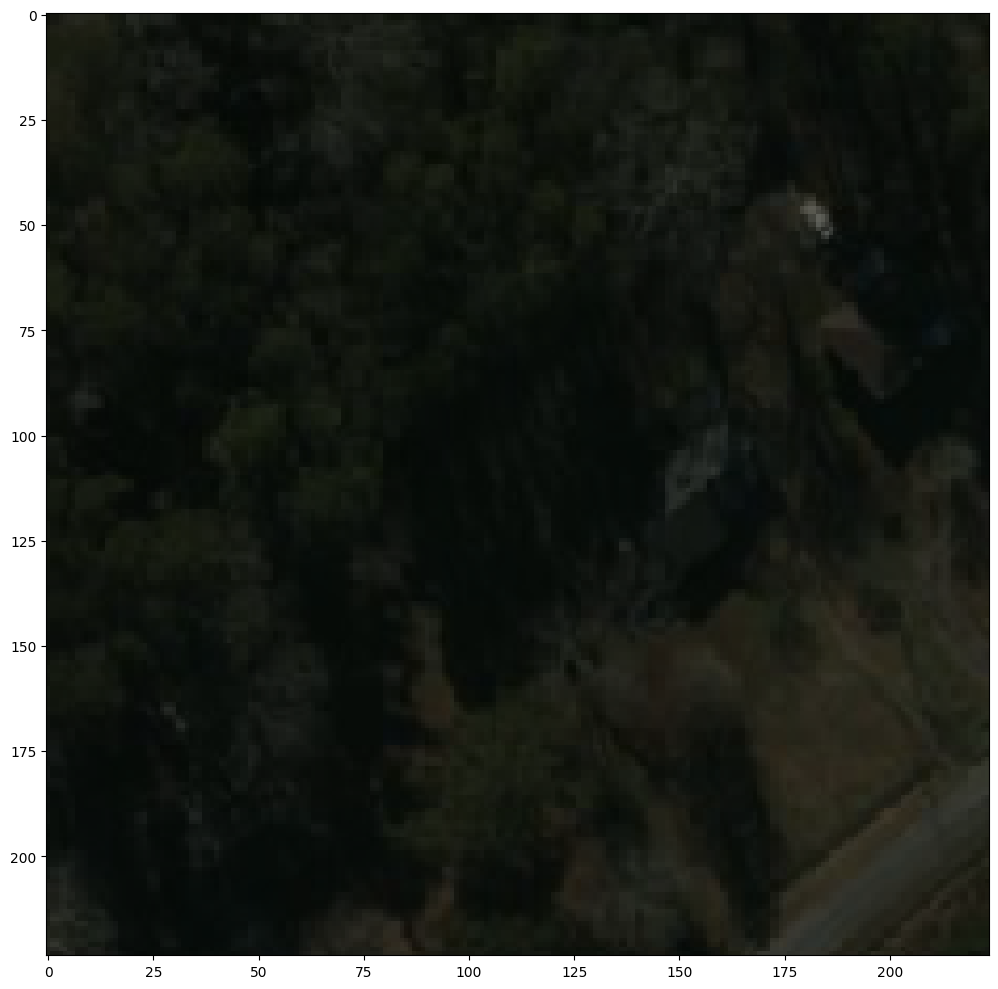

In [8]:
checkpoint_file = 'mmsegmentation/building_checkpoint/iter_10000.pth'  # 학습된 가중치 파일

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

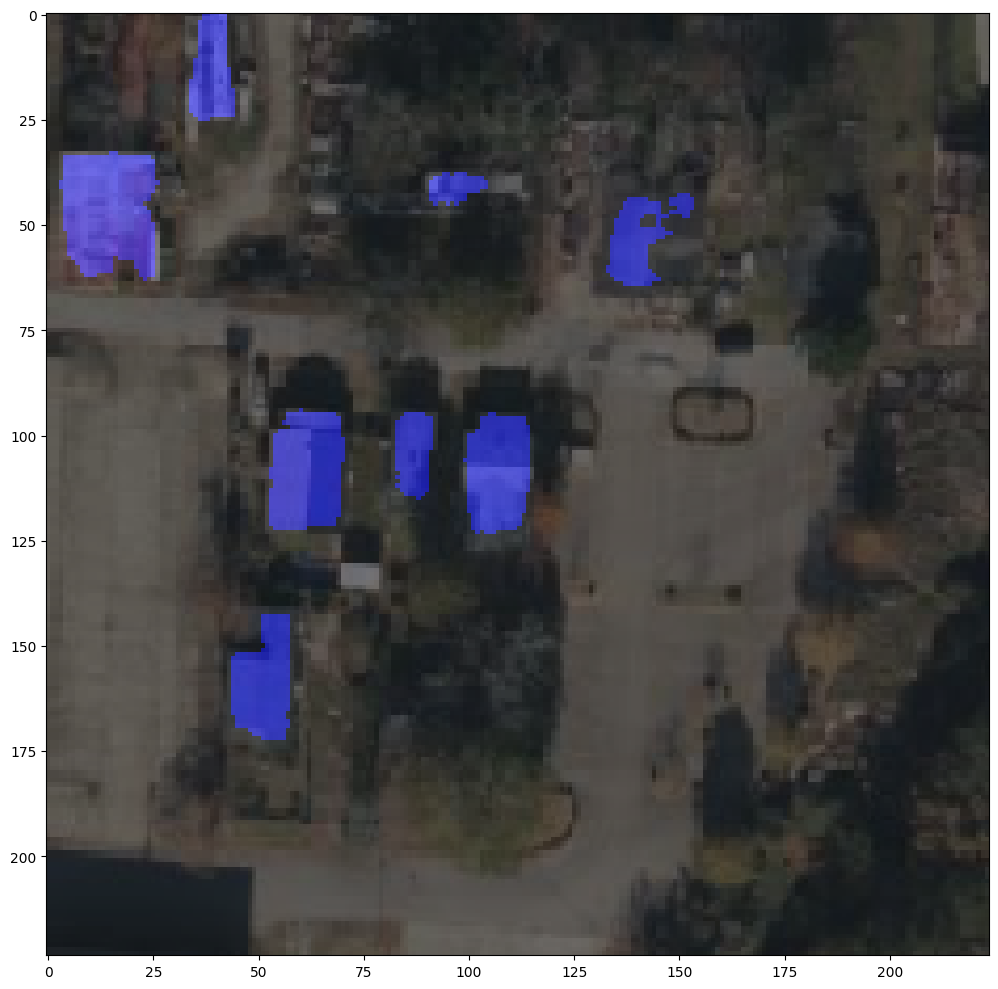

In [9]:
import cv2
img = mmcv.imread('./test_img/TEST_40654.png') # inference할 이미지
# resized_img = cv2.resize(img, dsize=(0,0), fx = 4.571428571428571, fy =4.571428571428571, interpolation=cv2.INTER_LINEAR)
# print(resized_img.shape)
result = inference_segmentor(model_ckpt, img)
rlt = np.array(result[0])

show_result_pyplot(model_ckpt, img, result, palette)

In [9]:
from mmseg.datasets import (build_dataloader, build_dataset)

# test용 Dataset과 DataLoader 생성. 
# build_dataset()호출 시 list로 감싸지 않는 것이 train용 dataset 생성시와 차이. 
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        # 반드시 아래 samples_per_gpu 인자값은 1로 설정
        #samples_per_gpu=cfg.data.samples_per_gpu,
        #workers_per_gpu=cfg.data.workers_per_gpu,
        samples_per_gpu=1,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)

2023-07-26 13:20:27,196 - mmseg - INFO - Loaded 60640 images


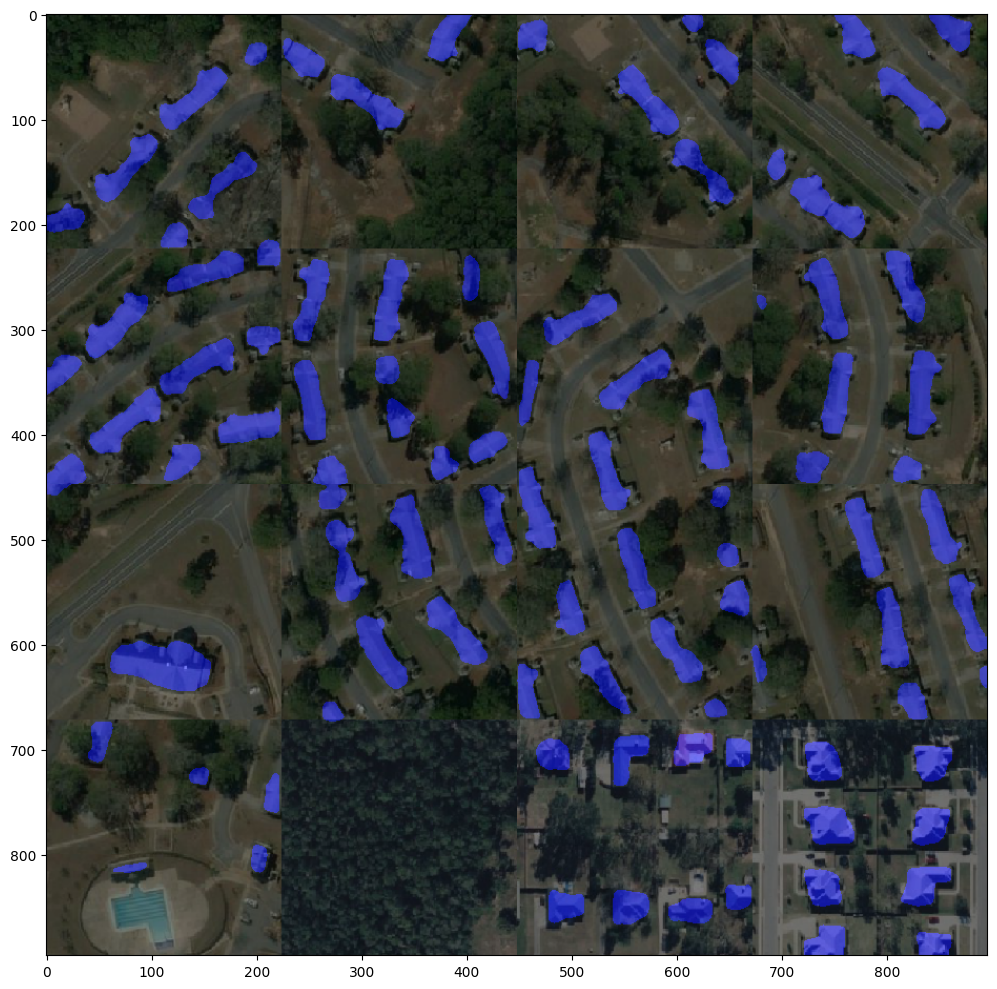

In [9]:
import numpy as np, cv2


imgs = [['./test_img/TEST_10000.png', './test_img/TEST_10001.png', './test_img/TEST_10002.png', './test_img/TEST_10003.png'],
       ['./test_img/TEST_10004.png', './test_img/TEST_10005.png', './test_img/TEST_10006.png', './test_img/TEST_10007.png'],
       ['./test_img/TEST_10008.png', './test_img/TEST_10009.png', './test_img/TEST_10010.png', './test_img/TEST_10011.png'], 
       ['./test_img/TEST_10012.png', './test_img/TEST_10013.png', './test_img/TEST_10014.png', './test_img/TEST_10015.png']]

# imgs = [
# ['TRAIN_0010','TRAIN_0036','TRAIN_0037','TRAIN_0058'],
# ['TRAIN_0061','TRAIN_0080','TRAIN_0094','TRAIN_0098'],
# ['TRAIN_0113','TRAIN_0118','TRAIN_0133','TRAIN_0153'],
# ['TRAIN_0165','TRAIN_0175','TRAIN_0185','TRAIN_0187']]
img = []
for i in range(4):
    tmp = []
    for j in range(4):
        tmp.append(mmcv.imread(imgs[i][j]))
    vertical = cv2.hconcat(tmp)
    img.append(vertical)
img = cv2.vconcat(img)


# concat_img = []
# concat_img.append(img)
# vis = np.zeros((896, 128), dtype=np.uint8)
# vis2 = cv2.cvtColor(vis, cv2.COLOR_GRAY2RGB)
# concat_img.append(vis2)
# img = cv2.hconcat(concat_img)

# concat_img = []
# concat_img.append(img)
# vis = np.zeros((128, 1024), dtype=np.uint8)
# vis2 = cv2.cvtColor(vis, cv2.COLOR_GRAY2RGB)
# concat_img.append(vis2)
# img = cv2.vconcat(concat_img)


# # print(np.zeros([128,896]).shape)  
# img.append()
# print(img.shape)
# img.reshape((128,896))

        


result = inference_segmentor(model_ckpt, img)

show_result_pyplot(model_ckpt, img, result, palette)

In [13]:
img_num = 16 * 60

In [10]:
from mmseg.datasets import (build_dataloader, build_dataset)

# test용 Dataset과 DataLoader 생성. 
# build_dataset()호출 시 list로 감싸지 않는 것이 train용 dataset 생성시와 차이. 
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        # 반드시 아래 samples_per_gpu 인자값은 1로 설정
        #samples_per_gpu=cfg.data.samples_per_gpu,
        #workers_per_gpu=cfg.data.workers_per_gpu,
        samples_per_gpu=1,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)

2023-07-26 22:52:57,832 - mmseg - INFO - Loaded 60640 images


In [11]:
#60640/16 = 3790


from tqdm import tqdm

model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0') 
test_file = open("./split/test.txt", 'r')
test = test_file.readlines()
test_file.close()
result = []
buffer = []
for dirs in tqdm(test):
    dir = dirs.rstrip("\n")
    buffer.append(f"test_img/{dir}.png")
    if (len(buffer) == 16):
        img = []
        for i in range(4):
            tmp = []
            for j in range(4):
                tmp.append(mmcv.imread(buffer[i*4 + j]))
            vertical = cv2.hconcat(tmp)
            img.append(vertical)
        img = cv2.vconcat(img)
        img = inference_segmentor(model_ckpt, img)
        images = np.array(img[0])
#         croped_mask = []
        
        for i in range(4):
            for j in range(4):
#                 croped_mask.append(images[224 * i : 224 * (i+1), 224 * j : 224 * (j+1)])
                mask_rle = rle_encode(images[224 * i : 224 * (i+1), 224 * j : 224 * (j+1)])
                if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                    result.append(-1)
                else:
                    result.append(mask_rle)

                buffer = []


    
# print(result)

load checkpoint from local path: mmsegmentation/building_checkpoint/iter_10000.pth


100%|████████████████████████████████████████████████████████████████████████| 60640/60640 [5:25:10<00:00,  3.11it/s]


In [34]:
# print(result)

In [12]:
import pandas as pd

submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result

In [13]:
submit.to_csv('./submit.csv', index=False)